In [1]:
import numpy as np
np.set_printoptions(threshold=10000,suppress=True)
import warnings
warnings.filterwarnings('ignore')

### Globals

In [2]:
import os

# Dataset source : https://www.kaggle.com/datasets/asinow/diabetes-dataset

ROOT_DIR = os.path.dirname(os.getcwd())

DATA_DIR = os.path.join(ROOT_DIR, 'data')
RAW_DATA_PATH = os.path.join(DATA_DIR, 'raw_data.csv')
TEST_DATA_PATH = os.path.join(DATA_DIR, 'raw_test.csv')
REF_DATA_PATH = os.path.join(DATA_DIR, 'ref_data.csv')

PKL_DIR = os.path.join(ROOT_DIR, 'artifacts')
EMBEDDING_PATH = os.path.join(PKL_DIR, 'embedding.pkl')
SCALER_PATH = os.path.join(PKL_DIR, 'scaler.pkl')
PIPELINE_PATH = os.path.join(PKL_DIR, 'pipeline.pkl')

### Load raw data

In [3]:
import pandas as pd

df = pd.read_csv(RAW_DATA_PATH, sep=',')
x = df.drop(columns=['Outcome'])
y = df['Outcome']

### Save embedding and scaler 

In [10]:
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

embedding = PCA(n_components=16)
x_embedded = embedding.fit_transform(x)

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_embedded)

with open(EMBEDDING_PATH, 'wb') as f:
    pickle.dump(embedding, f)

with open(SCALER_PATH, 'wb') as f:
    pickle.dump(scaler, f)

ref_data = pd.DataFrame(x_scaled, columns=x.columns)
ref_data['Outcome'] = y

ref_data.to_csv(REF_DATA_PATH, index=False)

### Run benchmarks

In [5]:
from sklearn.naive_bayes import GaussianNB # type: ignore
from sklearn.tree import DecisionTreeClassifier # type: ignore
from sklearn.neighbors import KNeighborsClassifier # type: ignore
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier # type: ignore
from sklearn.neural_network import MLPClassifier # type: ignore
from xgboost import XGBClassifier # type: ignore
import numpy as np # type: ignore

clfs = {
    'Naive Bayes': GaussianNB(),
    'CART Tree': DecisionTreeClassifier(),
    'Decision Stump': DecisionTreeClassifier(max_depth=1),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Random Forest': RandomForestClassifier(n_estimators=200),
    'Bagging': BaggingClassifier(n_estimators=200),
    'AdaBoost': AdaBoostClassifier(n_estimators=200, algorithm='SAMME'),
    'XGBoost': XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric='logloss'),
    'MLP': MLPClassifier(hidden_layer_sizes=(20, 10), max_iter=500)
}

param_grid = {
    'Naive Bayes': {
        'var_smoothing': np.logspace(-9, -3, num=7)
    },
    'CART Tree': {
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    },
    'Decision Stump': {
        'min_samples_split': [2, 5, 10],
        'criterion': ['gini', 'entropy']
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'criterion': ['gini', 'entropy']
    },
    'Bagging': {
        'n_estimators': [50, 100, 200],
        'max_samples': [0.5, 0.75, 1.0],
        'max_features': [0.5, 0.75, 1.0],
        'bootstrap': [True, False]
    },
    'AdaBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.5, 1],
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 6, 10],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'use_label_encoder': [False, True]
    },
    'MLP': {
        'hidden_layer_sizes': [(20,), (20,10), (40, 20), (50,), (50,25)],
        'activation': ['relu', 'tanh', 'logistic'],
    }
}

In [6]:
from sklearn.neural_network import MLPClassifier # type: ignore

from utils import run_classifiers

_, _, (_, best_avg_model) = run_classifiers(X=x_scaled, Y=y, clfs=clfs)

 Best model for accuracy: MLPClassifier(hidden_layer_sizes=(20, 10), max_iter=500) [0.994]
 Best model for precision: DecisionTreeClassifier(max_depth=1) [1.000]
 Best model for auc: MLPClassifier(hidden_layer_sizes=(20, 10), max_iter=500) [1.000]
Best average model:  MLPClassifier(hidden_layer_sizes=(20, 10), max_iter=500) 0.9955252135807332


Using permutation importance for MLPClassifier...


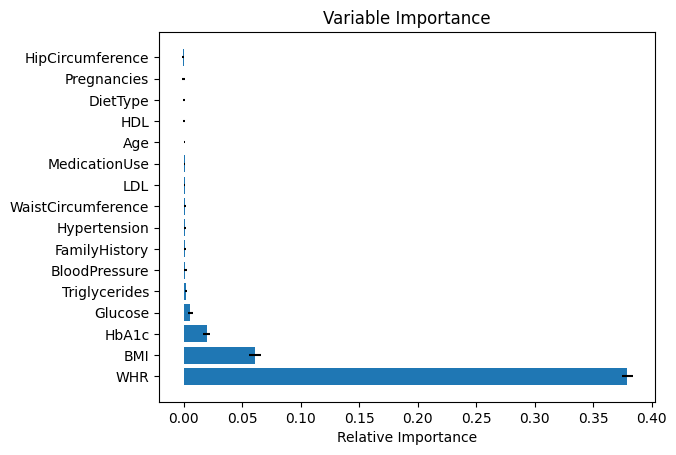

Nombre optimal de variables : 5


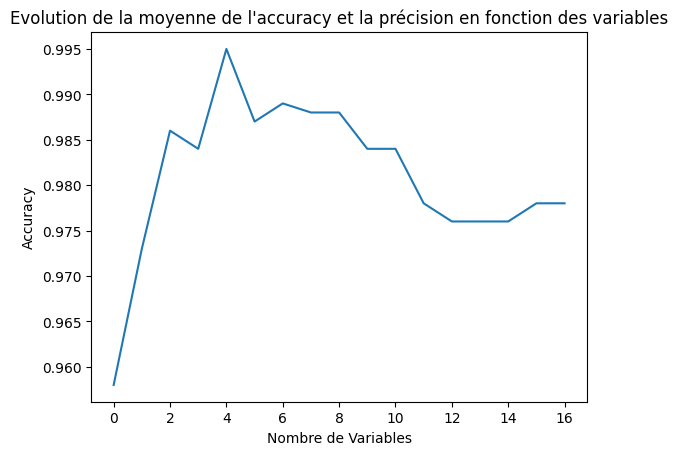

Meilleurs paramètres : {'activation': 'relu', 'hidden_layer_sizes': (20,)}
Meilleur score (Accuracy & Precision) : 0.9940318013560958


In [7]:
from utils import tune_classifier

df = pd.read_csv(TEST_DATA_PATH, sep=',')
x_test = df.drop(columns=['Outcome'])
y_test = df['Outcome']

embedding = PCA(n_components=16)
x_test_embedded = embedding.fit_transform(x_test)

scaler = StandardScaler()
x_test_scaled = scaler.fit_transform(x_test_embedded)

clf = clfs[best_avg_model]
params = param_grid[best_avg_model]
model = MLPClassifier(hidden_layer_sizes=(40, 20), random_state=1)
clf.fit(x_scaled, y)
optimal_params = tune_classifier(params, np.array(x.columns), model, x_scaled, x_test_scaled, y, y_test, clf=clf)

### Save pipeline

In [8]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('pca', PCA(n_components=16)),
    ('scaler', StandardScaler()),
    ('classifier', MLPClassifier(**optimal_params))
])

pipeline.fit(x, y)

with open(PIPELINE_PATH, 'wb') as f:
    pickle.dump(pipeline, f)